### Q1.1 Implement the noise reduction for the noisy image Q1_1.tif and submit your code and the denoised image. 

In [1]:
# importing packages
import numpy as np
from scipy import fftpack
import matplotlib.pyplot as plt
import cv2

In [ ]:
# reading image in grayscale
image = cv2.imread('images/Q1_1.tif',cv2.IMREAD_GRAYSCALE)
M, N = image.shape

In [ ]:
# To examine the spectrum of the image, we use fftn (instead of fft)
# to compute the DFT, since it has more than one dimension.
# The 2D FFT is equivalent to taking the 1D FFT across 
# rows and then across columns, or vice versa.

F = fftpack.fftn(image)
F_magnitude = np.abs(F)
F_magnitude = fftpack.fftshift(F_magnitude)

In [ ]:
# we take the log of the spectrum to compress the range of values,
f, ax = plt.subplots(figsize=(4.8, 4.8))

ax.imshow(np.log(1 + F_magnitude), cmap='viridis',
          extent=(-N // 2, N // 2, -M // 2, M // 2))
ax.set_title('Spectrum magnitude');

In [ ]:
# Set block around center of spectrum to zero
K = 40
F_magnitude[M // 2 - K: M // 2 + K, N // 2 - K: N // 2 + K] = 0

# Find all peaks higher than the 98th percentile
peaks = F_magnitude < np.percentile(F_magnitude, 98)

# Shift the peaks back to align with the original spectrum
peaks = fftpack.ifftshift(peaks)

# Make a copy of the original (complex) spectrum
F_dim = F.copy()

# Set those peak coefficients to zero
F_dim = F_dim * peaks.astype(int)

# Do the inverse Fourier transform to get back to an image.
# Since we started with a real image, we only look at the real part of
# the output.
image_filtered = np.real(fftpack.ifft2(F_dim))


# plotting images
f = plt.figure(figsize=(10,10))

ax1 = f.add_subplot(221)
ax1.imshow(np.log(1 + F_magnitude), 
          extent=(-N // 2, N // 2, -M // 2, M // 2), cmap='gray')
ax1.set_title('Spectrum with block')

ax2 = f.add_subplot(222)
ax2.imshow(image,cmap="gray")
ax2.set_title('Input image')

ax3 = f.add_subplot(223)
ax3.imshow(np.log10(1 + np.abs(F_dim)), cmap='gray')
ax3.set_title('Spectrum after suppression')

ax4 = f.add_subplot(224)
ax4.imshow(image_filtered, cmap='gray')
ax4.set_title('Filtered image')



### Q1.2 Implement the histogram equalization to the input images Q1_2.tif and Q1_3.tif and submit your code and the output images.

In [41]:
# importing images
img2= cv2.imread("images/Q1_2.tif",cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread("images/Q1_3.tif",cv2.IMREAD_GRAYSCALE)

In [17]:
def histogramEqualize(img,title):
    mat = img.copy()
    
    image_histogram,bins = np.histogram(mat.flatten(),256,density=True)
    cdf = image_histogram.cumsum()
    cdf = 255 * cdf / cdf[-1]
    image_equalized = np.interp(mat.flatten(), bins[:-1], cdf)
    r = np.round(image_equalized.reshape(mat.shape)).astype("uint8")
    
    # plotting histogram
    f = plt.figure(figsize=(10,4))
    
    rk,nk = np.unique(img,return_counts=True)
    ax = f.add_subplot(1,2,1)
    ax.set_xlim([0, 255])
    ax.bar(rk,nk)
    ax.set_title(f"{title}Input image Histogram")

    rk2,nk2 = np.unique(r,return_counts=True)
    ax2 = f.add_subplot(1,2,2)
    ax2.bar(rk2,nk2)
    ax2.set_title(f"{title}Histogram After Equalisation")
    
    return r

In [ ]:
img_out2 = histogramEqualize(img2,"Q1_2.tif ")


In [ ]:
img_out3 = histogramEqualize(img3,"Q1_3.tif ")

In [ ]:
displayAndSaveImg("Histogram Equalization of Q1_2.tif",img2,img_out2)
displayAndSaveImg("Histogram Equalization of Q1_3.tif",img3,img_out3)

In [14]:
# custom function to save image and display in a different window

def displayAndSaveImg(title="Result",*img):
    cv2.imwrite(f"{title}.png", np.concatenate(img,axis=1))
    cv2.imshow(title, np.concatenate(img,axis=1))
    cv2.waitKey(0)
    cv2.destroyAllWindows()

## 3

In [2]:
import pandas as pd

Text(0.5, 1.0, 'Image 4')

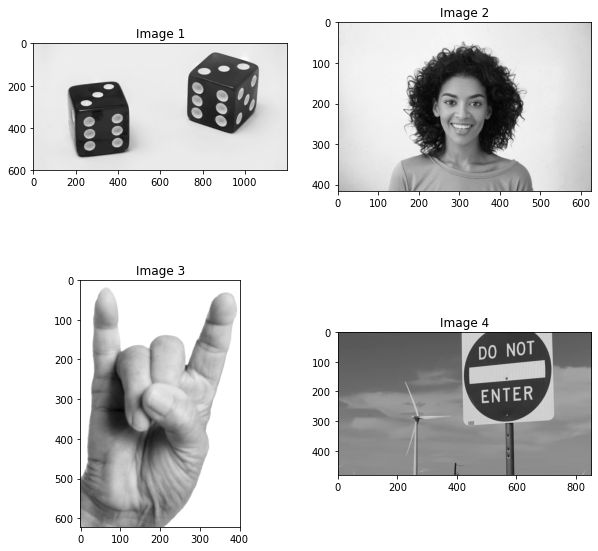

In [39]:
# reading dataset
img1 = cv2.imread("images/q3_1.jpg",cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("images/q3_2.jpg",cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread("images/q3_3.jpg",cv2.IMREAD_GRAYSCALE)
img4 = cv2.imread("images/q3_4.jpg",cv2.IMREAD_GRAYSCALE)

# displaying dataset
f = plt.figure(figsize=(10,10))

ax1 = f.add_subplot(221)
ax1.imshow(img1, cmap='gray')
ax1.set_title('Image 1')

ax2 = f.add_subplot(222)
ax2.imshow(img2, cmap='gray')
ax2.set_title('Image 2')

ax3 = f.add_subplot(223)
ax3.imshow(img3, cmap='gray')
ax3.set_title('Image 3')

ax4 = f.add_subplot(224)
ax4.imshow(img4, cmap='gray')
ax4.set_title('Image 4')

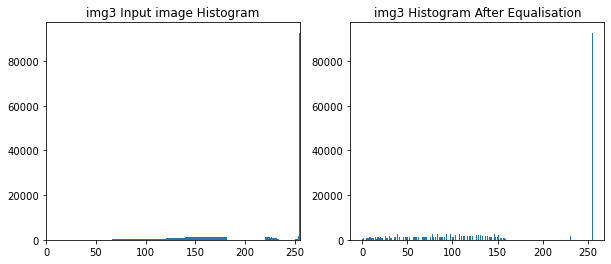

In [30]:
# pre processing image 3
# doing histogram equalisation on image 3
img3 = histogramEqualize(img3, "img3 ")

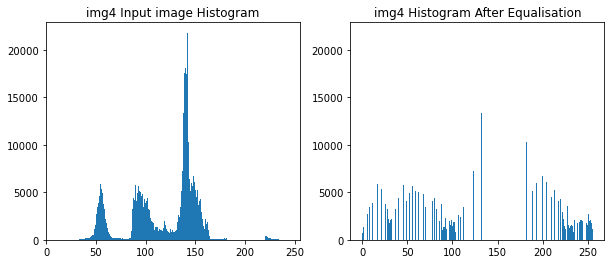

In [35]:
# pre processing image 4
# doing histogram equalisation on image 4
img4 = histogramEqualize(img4, "img4 ")

In [36]:
def otsu_segmentation(img):
    M,N = img.shape
    rk,nk = np.unique(img,return_counts=True)
    T = pd.DataFrame(columns=["th","wb","wf","mb","mf","Between Class Variance"])
    
    for t in range(rk.shape[0]):
        wb,wf = (nk[:t].sum()/(M*N)),(nk[t:].sum()/(M*N))
        if nk[:t].sum()!=0:
            mb,mf = (((nk[:t]*rk[:t]).sum())/(nk[:t].sum())),(((nk[t:]*rk[t:]).sum())/(nk[t:].sum()))
        else:
            mb,mf = 0,(((nk[t:]*rk[t:]).sum())/(nk[t:].sum()))
        D = { "th":rk[t], "wb":wb, "wf": wf, "mb":mb, "mf": mf, "Between Class Variance": wb*wf*((mb-mf)**2)}
        T = T.append(D,ignore_index= True)
    threshold  = T.sort_values(by=["Between Class Variance"],ascending=False).head(1)["th"].iloc[0]
    
    return threshold,T

In [37]:
def disp_img(title="Result",*img):
    cv2.imshow(title, np.concatenate(img,axis=1))
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [40]:
# image 4 segmentation
threshold,T = otsu_segmentation(img4)
displayAndSaveImg("img4 segmentation",img4,((img4>threshold )*255).astype("uint8"))
T

,th,wb,wf,mb,mf,Between Class Variance
0,0.0,0.000000,1.000000,0.000000,126.983656,0.000000
1,2.0,0.000015,0.999985,0.000000,126.985519,0.236577
2,3.0,0.000017,0.999983,0.285714,126.985825,0.274766
3,5.0,0.000020,0.999980,0.625000,126.986128,0.312340
4,7.0,0.000027,0.999973,1.818182,126.987023,0.421398
...,...,...,...,...,...,...
244,247.0,0.999980,0.000020,126.981257,249.625000,0.294233
245,248.0,0.999988,0.000012,126.982137,251.200000,0.188648
246,249.0,0.999990,0.000010,126.982433,252.000000,0.152868
247,252.0,0.999993,0.000007,126.982732,253.000000,0.116492


In [ ]:
disp_img("Asd",img6)

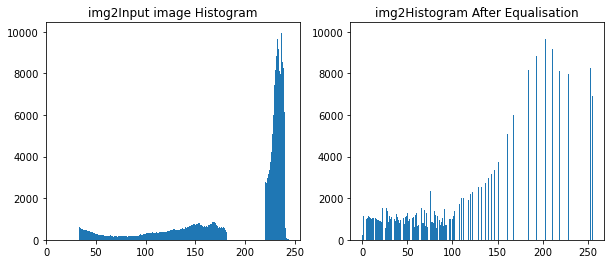